# Implementing FDNN

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
class FeedForward(nn.Module):

    def __init__(self, in_d=1, hidden=[4,4,4], dropout=0.1, activation=F.relu):
        super().__init__()
        self.sigma = activation
        dim = [in_d] + hidden + [1]
        self.layers = nn.ModuleList([nn.Linear(dim[i-1], dim[i]) for i in range(1, len(dim))])
        self.dp = nn.ModuleList([nn.Dropout(dropout) for _ in range(len(hidden))])

    def forward(self, t):
        t = t.to(next(self.layers[0].parameters()).device)  
        
        for i in range(len(self.layers)-1):
            t = self.layers[i](t)
            t = self.sigma(t)
            # apply dropout
            t = self.dp[i](t)
        # linear activation at the last layer
        return self.layers[-1](t)

In [3]:
import numpy as np
import pandas as pd
from pathlib import Path

### Data Loader

This module reads the Dataset from csv files and split it according to a pre-specific train/valid/test ratio. The Dataset is standardized.

In [4]:
from sklearn.preprocessing import StandardScaler

class DataLoader:

    def __init__(self, batch_size, X, Y, split=(8, 1, 1), random_seed=10294):        
        """
        batch_size : batch size, integer
        X - (n, J) : pandas.DataFrame for observed functional Data, n - subject number, J - number of time points
        Y - (n, 1) : pandas.DataFrame for response
        split      : train/valid/test split
        random_seed: random seed for training Data re-shuffle
        """        
        self.n, J = X.shape
        X, Y = X.values, Y.values

        # train/valid/test split
        self.batch_size = batch_size
        train_n = self.n // sum(split) * split[0]
        valid_n = self.n // sum(split) * split[1]
        test_n = self.n - train_n - valid_n
        self.train_B = train_n // batch_size
        self.valid_B = valid_n // batch_size
        self.test_B = test_n // batch_size

        # random shuffle
        np.random.seed(random_seed)
        _order = list(range(self.n))
        np.random.shuffle(_order)
        X = X[_order, :]
        Y = Y[_order, :]

        # standardize Dataset based on the training Dataset
        self.X_standardizer = StandardScaler()
        self.Y_standardizer = StandardScaler()

        # train/valid/test split
        self.train_X = X[:(self.train_B * self.batch_size), :]
        self.train_Y = Y[:(self.train_B * self.batch_size), :]
        self.X_standardizer.fit(self.train_X)
        self.Y_standardizer.fit(self.train_Y)
        self.train_X = self.X_standardizer.transform(self.train_X)
        self.train_Y = self.Y_standardizer.transform(self.train_Y)

        self.valid_X = X[(self.train_B * self.batch_size):((self.train_B + self.valid_B) * self.batch_size), :]
        self.valid_Y = Y[(self.train_B * self.batch_size):((self.train_B + self.valid_B) * self.batch_size), :]
        self.valid_X = self.X_standardizer.transform(self.valid_X)
        self.valid_Y = self.Y_standardizer.transform(self.valid_Y)

        self.test_X = X[((self.train_B + self.valid_B) * self.batch_size):, :]
        self.test_Y = Y[((self.train_B + self.valid_B) * self.batch_size):, :]
        self.test_X = self.X_standardizer.transform(self.test_X)
        self.test_Y = self.Y_standardizer.transform(self.test_Y)

    def shuffle(self):
        # re-shuffle the training Dataset
        train_size = self.train_X.shape[0]
        new_order = list(range(train_size))
        np.random.shuffle(new_order)
        self.train_X = self.train_X[new_order, :]
        self.train_Y = self.train_Y[new_order, :]

    def _batch_generator(self, X, Y, N):

        def generator_func():
            for i in range(1, N):
                x = X[((i - 1) * self.batch_size):((i) * self.batch_size), :]
                y = Y[((i - 1) * self.batch_size):((i) * self.batch_size), :]

                yield torch.Tensor(x), torch.Tensor(y)

        return generator_func()

    def get_train_batch(self):
        return self._batch_generator(self.train_X, self.train_Y, self.train_B)

    def get_valid_batch(self):
        return self._batch_generator(self.valid_X, self.valid_Y, self.valid_B)

    def get_test_batch(self):
        return self._batch_generator(self.test_X, self.test_Y, self.test_B)

# training the model

In [5]:
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from torch.optim import Adam

A Dataset will be generated if it is not present. 

Here, we set the measurement error variance to be 1 and noise variance to be 0.2.

**Note**: in this example, we use a flexible time point gap (**not** equal spacing). 

In [6]:
batch_size = 32
split = (64, 16, 20)

In [7]:
dataset_path = './1st_task'

X = pd.read_csv(dataset_path + "/X.csv", header=None)
Y = pd.read_csv(dataset_path + "/Y.csv", header=None)

DataLoader = DataLoader(batch_size,  X, Y, split)

Prepare the model and other training configurations:

In [8]:
# set up CPU/GPU
device = torch.device("cuda") 
# model configuration
"""
You can use a different model by modifing base_hidden, sub_hidden, n_base.
"""
hidden = [64, 128, 128, 64]
in_d = 48
dropout = 0
save_model_every = 10
model = FeedForward(in_d=48, 
                    hidden=hidden,
                    dropout=dropout)
# send model to CPU/GPU
_ = model.to(device)

In [9]:
next(model.parameters()).device

device(type='cuda', index=0)

In [10]:
# training configuration
epoch = 110
pred_loss_train_history = []
total_loss_train_history = []
loss_valid_history = []
# instantiate an optimizer
optimizer = Adam(model.parameters(), lr=3e-4)
# use MSE loss
compute_loss = torch.nn.MSELoss()
min_valid_loss = sys.maxsize

Create a folder to save checkpoints.

In [11]:
folder = "train/"
Path(folder).mkdir(parents=True, exist_ok=True)

Save and load models:

In [12]:
def save_model(folder, k, in_d, hidden, dropout, model, optimizer):
    checkpoint = {'in_d': in_d,
                  'hidden': hidden,
                  'dropout': dropout,
                  'state_dict': model.state_dict(),
                  'optimizer': optimizer.state_dict()}
    torch.save(checkpoint, folder + str(k) + '_' + 'checkpoint.pth')


def load_model(file_path):
    checkpoint = torch.load(file_path)
    model = FeedForward(in_d=checkpoint['in_d'],
                        hidden=checkpoint['hidden'],
                        dropout=checkpoint['dropout'])
    model.load_state_dict(checkpoint['state_dict'])
    _ = model.to(device)
    return model, checkpoint

training procedure:

In [13]:

for k in range(epoch):

    if k and k % save_model_every == 0:
        save_model(folder, k, in_d, hidden, dropout, model, optimizer)

    pred_loss_train = []
    total_loss_train = []
    loss_valid = []
    DataLoader.shuffle()
    # set model training state
    model.train()

    for i, (x, y) in enumerate(DataLoader.get_train_batch()):
        x, y = x.to(device), y.to(device)
        out = model.forward(x)
        loss_pred = compute_loss(out, y)
        loss = loss_pred
        # record training loss history
        total_loss_train.append(loss.item())
        pred_loss_train.append(loss_pred.item())

        # update parameters using backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    total_loss_train_history.append(np.mean(total_loss_train))
    pred_loss_train_history.append(np.mean(pred_loss_train))

    # model evaluation mode

    with torch.no_grad():
        model.eval()
        for x, y in DataLoader.get_valid_batch():
            x, y = x.to(device), y.to(device)
            valid_y = model.forward(x)
            valid_loss = compute_loss(valid_y, y)
            # print("valid - check out: ", check_tensor([valid_loss]))
            loss_valid.append(valid_loss.item())

    if np.mean(loss_valid) < min_valid_loss:
        save_model(folder, "best", in_d, hidden, dropout, model, optimizer)
        min_valid_loss = np.mean(loss_valid)

    loss_valid_history.append(np.mean(loss_valid))
    
    if (k+1) % 10 == 0:
        print("epoch:", k+1, "\n",
              "prediction training loss = ", pred_loss_train_history[-1],
              "validation loss = ", loss_valid_history[-1])
        

epoch: 10 
 prediction training loss =  0.05494152910050449 validation loss =  0.04233554417554002
epoch: 20 
 prediction training loss =  0.053231118135837786 validation loss =  0.048308221623301506
epoch: 30 
 prediction training loss =  0.049271155849372576 validation loss =  0.04440114840578575
epoch: 40 
 prediction training loss =  0.0442998923976487 validation loss =  0.045847154437349394
epoch: 50 
 prediction training loss =  0.04445603751329654 validation loss =  0.04810645520830384
epoch: 60 
 prediction training loss =  0.04106965889180199 validation loss =  0.051375452017125026
epoch: 70 
 prediction training loss =  0.04685269112040827 validation loss =  0.05041803455410095
epoch: 80 
 prediction training loss =  0.03235918486815527 validation loss =  0.05546562230357757
epoch: 90 
 prediction training loss =  0.05710681752993836 validation loss =  0.057949331087561756
epoch: 100 
 prediction training loss =  0.035875766627798115 validation loss =  0.053897290920408875
ep

Please note that the validation error was computed after a training epoch was complete. So the validation error is generally smaller than the training error. 

Make a loss plot after training finishes.

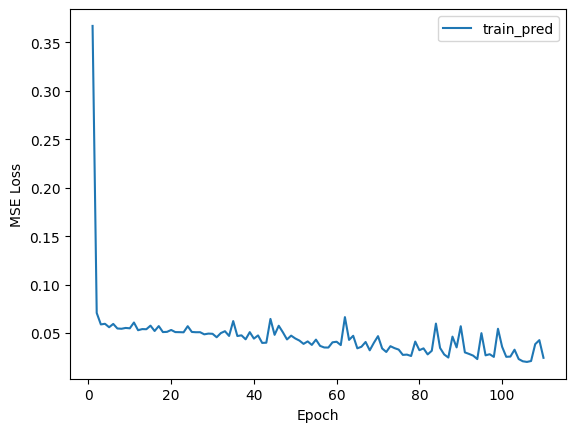

In [14]:
plt.plot(list(range(1, epoch + 1)), pred_loss_train_history, label='train_pred')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

After training, to make predictions, we can load the best model and run it on the (test) Dataset.

In [15]:
def make_prediction(DataLoader, folder="train/"):
    ck = folder + "best_checkpoint.pth"
    # load the best model
    model, t = load_model(ck)
    
    loss_test  = []
    y_pred = []
    
    with torch.no_grad():
        model.eval()
        """
        Get the performance of the best train model on test Dataset
        """
        for x, y in DataLoader.get_test_batch():
            x, y = x.to(device), y.to(device)
            test_y = model.forward(x)
            y_pred.extend(test_y.detach().cpu().numpy().tolist())
            test_loss = compute_loss(test_y, y)
            loss_test.append(test_loss.item()) 
        
    """
    Compute the MSE of the test Dataset
    """
    print("test accuracy MSE :", np.mean(loss_test))
    
    """
    return the predicted y values by re-scaling the model output
    """
    
    return DataLoader.Y_standardizer.inverse_transform(y_pred)


In [16]:
y_pred_test = make_prediction(DataLoader)

test accuracy MSE : 0.04693774692714214
